<a href="https://colab.research.google.com/github/Dogdriip/keras-study/blob/main/4_8_Convolutional_Stateful_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8. 문장(시계열수치)입력 이진분류 모델

## 1. 데이터셋 준비

- trainset 25000개, testset 25000개
- 각 샘플 하나는 영화 리뷰 하나를 나타냄
- label은 1: 좋아요, 0: 싫어요
- 데이터셋은 정수로 인코딩됨 (정수값은 단어의 빈도수를 나타냄)
- 모든 단어를 고려할 수 없으므로, 빈도수가 높은 단어를 위주로 데이터셋을 생성
- num_words := 해당 번째까지로 많이 사용하는 단어까지만 데이터셋으로 생성
- *첫번째 훈련용 리뷰(X_train[0], y_train[0])에서 리뷰 본문에 해당하는 X_train[0]에는 숫자들이 들어있습니다. 이 데이터는 토큰화와 정수 인코딩이라는 텍스트 전처리가 끝난 상태입니다. IMDB 리뷰 데이터는 전체 데이터에서 각 단어들의 등장 빈도에 따라서 인덱스를 부여했습니다.숫자가 낮을수록 이 데이터에서 등장 빈도 순위가 높습니다.*

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten, Dropout, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
max_features = 20000
text_max_words = 200

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [4]:
print(x_train)
print(len(x_train))
print(y_train)
print(len(y_train))

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 

In [5]:
print(x_test)
print(len(x_test))
print(y_test)
print(len(y_test))

[list([1, 591, 202, 14, 31, 6, 717, 10, 10, 18142, 10698, 5, 4, 360, 7, 4, 177, 5760, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 7944, 100, 28, 1668, 14, 31, 23, 27, 7479, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 15387, 38, 32, 25, 7944, 451, 202, 14, 6, 717])
 list([1, 14, 22, 3443, 6, 176, 7, 5063, 88, 12, 2679, 23, 1310, 5, 109, 943, 4, 114, 9, 55, 606, 5, 111, 7, 4, 139, 193, 273, 23, 4, 172, 270, 11, 7216, 10626, 4, 8463, 2801, 109, 1603, 21, 4, 22, 3861, 8, 6, 1193, 1330, 10, 10, 4, 105, 987, 35, 841, 16873, 19, 861, 1074, 5, 1987, 17975, 45, 55, 221, 15, 670, 5304, 526, 14, 1069, 4, 405, 5, 2438, 7, 27, 85, 108, 131, 4, 5045, 5304, 3884, 405, 9, 3523, 133, 5, 50, 13, 104, 51, 66, 166, 14, 22, 157, 9, 4, 530, 239, 34, 8463, 2801, 45, 407, 31, 7, 41, 3778, 105, 21, 59, 299, 12, 38, 950, 5, 4521, 15, 45, 629, 488, 2733, 127, 6, 52, 292, 17, 4, 6936, 185, 132, 1988, 5304, 1799, 488, 2693, 47, 6, 392, 173, 4, 2, 4378, 270, 2352, 4

- 실제로 어떤 단어로 이루어져 있는지 알아보자
- *imdb.get_word_index()에 각 단어와 맵핑되는 정수가 저장되어져 있습니다. 주의할 점은 imdb.get_word_index()에 저장된 값에 +3을 해야 실제 맵핑되는 정수입니다. 이것은 IMDB 리뷰 데이터셋에서 정한 규칙입니다.*
- *index_to_word에 인덱스를 집어넣으면 전처리 전에 어떤 단어였는지 확인할 수 있습니다. IMDB 리뷰 데이터셋에서는 0, 1, 2, 3은 특별 토큰으로 취급하고 있습니다. 그래서 정수 4부터가 실제 IMDB 리뷰 데이터셋에서 빈도수가 가장 높은 실제 영단어입니다.*

In [6]:
word_to_index = imdb.get_word_index()
index_to_word={}
for key, value in word_to_index.items():
    index_to_word[value+3] = key

In [7]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

' '.join([index_to_word[index] for index in x_train[0]])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <unk> is an amazing actor and now the same being director <unk> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <unk> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be pr

- 검증셋 분리

In [8]:
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

- 각 샘플의 길이는 모두 다르다 (리뷰의 길이가 당연히 모두 다르므로)
- 모델의 입력으로 사용하려면 고정된 길이로 만들어야 한다
- keras.preprocessing.sequence.pad_sequences()
  - 문장의 길이를 maxlen 인자로 **정확히** 맞춰줌.
    - 길면 자르고, 남으면 0으로 채움
  - (num_samples, num_timesteps)로 2차원 numpy 배열로 만들어줌. num_timesteps는 maxlen과 동일하게 설정됨.

In [9]:
from keras.preprocessing import sequence

x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

# 2. 레이어 준비

# 3. 모델 준비

- 순환 컨볼루션 신경망 모델
- Embedding: 단어를 의미론적 기하공간에 매핑. 
  - input_dim := 단어 사전의 크기. 단어가 최대 몇 종류 등장하는가? (이 예제에서는 맨 위의 num_words)
  - output_dim := 단어를 인코딩한 후 나오는 벡터 크기. 128이라면 단어를 128차원의 의미론적 기하공간에 매핑한다는 뜻.
  - input_length := 단어의 수, 즉 문장의 길이. 
- MaxPooling1D: 특징벡터의 수를 줄여줌.
- 200개 단어가 Conv1D 레이어를 통과하면 256 크기를 갖는 특징벡터가 198개 생성되고, MaxPooling1D는 특징벡터 198개 중 49개를 골라줌.
- 따라서 LSTM 레이어의 timestep은 49개. input_dim은 256개.

In [10]:
# 모델 구성
model = Sequential()
model.add(Embedding(max_features, 128, input_length=text_max_words))  # input_dim, output_dim, input_length
model.add(Dropout(0.2))
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [11]:
# 모델 학습과정 설명하기
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 256)          98560     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,855,809
Trainable params: 2,855,809
Non-trainable params: 0
______________________________________________

In [12]:
# 모델 학습
hist = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/10
313/313 [==============================] - 16s 39ms/step - loss: 0.5056 - accuracy: 0.7175 - val_loss: 0.3301 - val_accuracy: 0.8550
Epoch 2/10
313/313 [==============================] - 11s 36ms/step - loss: 0.1697 - accuracy: 0.9390 - val_loss: 0.3214 - val_accuracy: 0.8744
Epoch 3/10
313/313 [==============================] - 11s 35ms/step - loss: 0.0819 - accuracy: 0.9750 - val_loss: 0.4728 - val_accuracy: 0.8494
Epoch 4/10
313/313 [==============================] - 11s 36ms/step - loss: 0.0402 - accuracy: 0.9890 - val_loss: 0.4134 - val_accuracy: 0.8594
Epoch 5/10
313/313 [==============================] - 11s 35ms/step - loss: 0.0296 - accuracy: 0.9914 - val_loss: 0.6438 - val_accuracy: 0.8510
Epoch 6/10
313/313 [==============================] - 11s 36ms/step - loss: 0.0206 - accuracy: 0.9935 - val_loss: 0.5390 - val_accuracy: 0.8580
Epoch 7/10
313/313 [==============================] - 11s 37ms/step - loss: 0.0144 - accuracy: 0.9950 - val_loss: 0.6906 - val_accuracy:

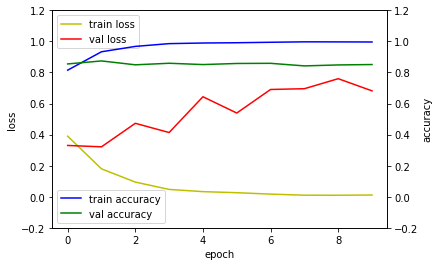

In [13]:
# 학습과정 살펴보기
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [14]:
# 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print(loss_and_metrics)

391/391 [==============================] - 2s 5ms/step - loss: 0.7692 - accuracy: 0.8365
[0.7691960334777832, 0.8365200161933899]


In [15]:
yhat_test = model.predict(x_test, batch_size=64)

In [16]:
yhat_test

array([[2.8197063e-04],
       [9.9971038e-01],
       [1.1261422e-01],
       ...,
       [1.2517584e-03],
       [1.9081619e-02],
       [9.9670756e-01]], dtype=float32)

In [17]:
# 결과 잘 나오는지 테스트
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

' '.join([index_to_word[index] for index in x_test[1]])

"psychological trickery it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant performance by sandy dennis it's definitely one of her darker characters but she plays it so perfectly and convincingly that it's scary michael burns does a good job as the mute young man regular altman player michael murphy has a small part the <unk> moody set fits the content of the story very well in short this movie is a powerful study of loneliness sexual repression and desperation be patient <unk> up the atmosphere and pay attention to the wonderfully written script br br i praise robert altman this is one of his many films that deals with unconventional fascinating subject matter this film is disturbing but it's sincere and it's sure to elicit a strong emotional response from the viewer if you want to see an unusual film some 

In [18]:
yhat_test[1]

array([0.9997104], dtype=float32)

In [19]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

' '.join([index_to_word[index] for index in x_test[100]])

"<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <sos> a quick glance at the premise of this film would seem to indicate just another dumb '80's inbred <unk> slash fest the type where sex equals death and the actors are all annoying stereotypes you actually want to die however delivers considerably more br br rather than focus on bare flesh and gore though there is a little of each no sex however the flick focuses on delivering impending dread mounting tension amidst a lovely scenic backdrop these feelings are further heightened by a cast of realistically likable characters and antagonists that are more amoral than cardboard <unk> of evil oh yeah geo

In [20]:
yhat_test[100]

array([0.00150752], dtype=float32)